#Generate clips
Generate 2-sec + call length clips along with mask files (0's where no call, 1's where call) and save to use as training data. Use all labeled files in round 1.

Output clips to /content/drive/My Drive/MeerkatCallDetector/clips

Save in format:
calltype##_aud.npy
calltype##_mask.npy

In [5]:
#Generate samples for use as training data
#Generate files and store in clips folder

#NOTE: Using SS and RY files for validation not training - as of May 2019 (ari_labels_only = True)

#params
base_dir = '/home/arianasp/meerkat_detector'
ari_labels_only = True
load_labels = True
generate_clips = True
focal = False #whether to run for focal obs recordings from collaring experiment (otherwise run for collar recordings)
focal_megan = False #whether to run on focal obs recordings collected from Megan
validation = True

#Directories
ground_truth_dir = base_dir + '/ground_truth'
code_dir = base_dir + '/dev'
audio_dir = base_dir + '/data/full_recordings' 
focal_megan_dir = '/media/arianasp/Elements/Sound files/Pups VS No Pups'

#Leave one file out for later validation
#validation_file = 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS' #used for collar data
#validation_file = 'HM_VHMM003_SOUNDFOC_20170905_3_label' #used for focal data

#import libraries
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import re
import IPython.display as ipd

#Set path
sys.path.append(code_dir)

#Import library
from meerkat_call_detector_library import *

if(load_labels and not focal_megan):

  #Read in all training data
  ground_truth_files = os.listdir(ground_truth_dir)

  #Remove sound focals or use only sound focals
  if(focal):
    #ground_truth_files = [s for s in ground_truth_files if('SOUNDFOC' in s)]
    ground_truth_files = [s for s in ground_truth_files if('SOUNDFOC' in s)]
  else:
    ground_truth_files = [s for s in ground_truth_files if(not('SOUNDFOC' in s))]
  print(ground_truth_files)
    
  #Remove data from validation file (will be used later) - removed because all SS and RY files will now be validation
  #ground_truth_files = [s for s in ground_truth_files if(not(validation_file in s))]

  #Remove files lableed by other peoples (to use as testing data)
  if(ari_labels_only and not(validation)):
    ground_truth_files = [s for s in ground_truth_files if(("label.csv" in s) or ('label.CSV' in s))]
    
  if(validation):
    

  labels_all = pandas.DataFrame()

  for file in ground_truth_files:

    #Read in curent labels for each file
    labels = pandas.read_csv(ground_truth_dir + '/' + file,delimiter='\t')

    #convert times to seconds
    labels['start_time'] = labels['Start'].map(lambda x: hms_to_seconds(x))
    labels['duration'] = labels['Duration'].map(lambda x: hms_to_seconds(x))
    labels['end_time'] = labels['start_time'] + labels['duration']

    #Add columns for label types
    labels['label_type'] = labels['Name'].apply(label_type)
    labels['call_type'] = labels['Name'].apply(call_type_simple)
    labels['focal'] = labels['Name'].apply(caller)

    #Add column for filename
    labels['file'] = file

    #Add None where appropriate
    labels.loc[labels['label_type'] != 'call','call_type'] = None
    labels.loc[labels['label_type'] != 'call','focal'] = None

    labels_all = labels_all.append(labels,ignore_index=True)

  labels = labels_all
  
if(generate_clips and not(focal_megan)):

  #generate 2 sec clips and save to clips folder
  if(focal):
    clips_dir = base_dir + '/clips_foc'
  elif(focal_megan):
    clips_dir = base_dir + '/clips_foc_megan'
  elif(validation):
    clips_dir = base_dir + '/clips_validate'
  else:
    clips_dir = base_dir + '/clips'
  samprate = 8000 

  n_labels = len(labels.index)

  for i in labels.index:
    print(str(i) + '/' + str(n_labels))
    call_type = labels['call_type'][i]
    if(call_type != None):
        t0 = labels['start_time'][i] - 1
        tf = labels['end_time'][i] + 1
        file = labels['file'][i]
        
        if(focal):
          path_aud = audio_dir + '/' + file[0:(len(file)-4)] + '_downsamp.wav'
        else:
          path_aud = audio_dir + '/' + file[0:(len(file)-4)] + '.wav'
        aud, sr = librosa.core.load(path=path_aud,sr=samprate,offset=t0,duration=tf-t0)

        #get mask
        labs_curr = labels[(labels['file']==file) & (labels['start_time']>= t0) & (labels['end_time']<= tf) & (labels['call_type']!= None)]
        nrow = labs_curr.shape[0]
        mask = np.zeros(shape=len(aud))
        for j in labs_curr.index:
          t0_call = np.int(np.round((labs_curr['start_time'][j] - t0)*samprate))
          tf_call = np.int(np.round((labs_curr['end_time'][j] - t0)*samprate))
          if(t0_call < 0):
            t0_call = 0
          mask[t0_call:tf_call] = 1
        clip_file_name = call_type + str(i)
        np.save(clips_dir + '/' + clip_file_name + '_mask.npy',mask)
        np.save(clips_dir + '/' + clip_file_name + '_aud.npy',aud)

  #save list of labels
  fid = open(clips_dir + '/' + 'labels_all.pckl','wb')
  pickle.dump(labels,fid)
  fid.close()

if(generate_clips and focal_megan):
    labels_train_file = '/home/arianasp/meerkat_detector/labels_megan/focal_labels_train.csv'
    wav_dir = '/media/arianasp/Elements/Sound Files/Pups VS No Pups'
    clips_dir = '/home/arianasp/meerkat_detector/clips_foc_megan'
    samprate=8000
    labels = pandas.read_csv(labels_train_file,delimiter=',',dtype=object)

    #Convert European formatted numbers to decimal format
    labels["t0"] = labels["t0"].str.replace(",",".").astype(float)
    labels["tf"] = labels["tf"].str.replace(",",".").astype(float)

    #Loop over all labels and create clips and masks for each
    for i in range(labels.shape[0]):
        print(i)
        filename = labels['filename'][i]
        call_type = labels['type'][i]
        t0 = float(labels['t0'][i]) - 1
        tf = float(labels['tf'][i]) + 1
        iscall = labels['iscall'][i]
        if iscall=='TRUE':
            file_str = filename[0:(len(filename)-4)]
            matches = glob.glob(wav_dir + '/**/[nN][oO] [pP][uU][pP][sS]/**/' + file_str + '_LEFT_8000.[wW][aA][vV]',recursive=True)
            if len(matches)==1 and t0>0:
                path_aud = matches[0]
                aud, sr = librosa.core.load(path=path_aud,sr=samprate,offset=t0,duration=tf-t0)
                labs_curr = labels[(labels['filename']==filename) & (labels['t0']>= t0) & (labels['tf']<= tf) & (labels['iscall']== 'TRUE')]
                if (sum(labs_curr['type'].str.contains('end'))==0) and (sum(labs_curr['type'].str.contains('start'))==0):
                    nrow = labs_curr.shape[0]
                    mask = np.zeros(shape=len(aud))
                    for j in labs_curr.index:
                        t0_call = np.int(np.round((labs_curr['t0'][j] - t0)*samprate))
                        tf_call = np.int(np.round((labs_curr['tf'][j] - t0)*samprate))
                        if(t0_call < 0):
                            t0_call = 0
                        mask[t0_call:tf_call] = 1
                    clip_file_name = call_type + str(i)
                    print(clips_dir + '/' + clip_file_name)
                    print(matches)
                    np.save(clips_dir + '/' + clip_file_name + '_mask.npy',mask)
                    np.save(clips_dir + '/' + clip_file_name + '_aud.npy',aud)

['HM_HRT_R09_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221110_LABEL_RY.csv', 'HM_RT_R10_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221102_SS.csv', 'HM_HTB_R14_file_4_(2017_08_23-06_44_59)_ASWMUX221052._labelSS.csv', 'HM_LT_R07_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221092_label.csv', 'HM_HRT_R07_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221092_LABEL_RY.csv', 'HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv', 'HM_RT_R10_20170903-20170908_file_4_(2017_09_05-05_44_59)_ASWMUX221102_label.CSV', 'HM_PET_R11_20170903-20170908_file_3_(2017_09_04-05_44_59)_ASWMUX221163_label.csv', 'HM_RT_R12_file_4_(2017_08_23-06_44_59)_ASWMUX221102_labelSS.csv', 'HM_LT_R07_AUDIO_file_4_(2017_08_23-06_44_59)_ASWMUX221092_LABEL_RY.csv', 'HM_HTB_R14_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221052_label.CSV', 'HM_LT_R07_AUDIO_file_5_(2017_08_24-06_44_59)_ASWMUX221092_SS.csv', 'HM_HRT_R09_AUDIO_file_6_(2017_08_25-06_44_59)_ASWMUX221110_label.csv', 'HM_

685/7373
686/7373
687/7373
688/7373
689/7373
690/7373
691/7373
692/7373
693/7373
694/7373
695/7373
696/7373
697/7373
698/7373
699/7373
700/7373
701/7373
702/7373
703/7373
704/7373
705/7373
706/7373
707/7373
708/7373
709/7373
710/7373
711/7373
712/7373
713/7373
714/7373
715/7373
716/7373
717/7373
718/7373
719/7373
720/7373
721/7373
722/7373
723/7373
724/7373
725/7373
726/7373
727/7373
728/7373
729/7373
730/7373
731/7373
732/7373
733/7373
734/7373
735/7373
736/7373
737/7373
738/7373
739/7373
740/7373
741/7373
742/7373
743/7373
744/7373
745/7373
746/7373
747/7373
748/7373
749/7373
750/7373
751/7373
752/7373
753/7373
754/7373
755/7373
756/7373
757/7373
758/7373
759/7373
760/7373
761/7373
762/7373
763/7373
764/7373
765/7373
766/7373
767/7373
768/7373
769/7373
770/7373
771/7373
772/7373
773/7373
774/7373
775/7373
776/7373
777/7373
778/7373
779/7373
780/7373
781/7373
782/7373
783/7373
784/7373
785/7373
786/7373
787/7373
788/7373
789/7373
790/7373
791/7373
792/7373
793/7373
794/7373
795/7373
7

1536/7373
1537/7373
1538/7373
1539/7373
1540/7373
1541/7373
1542/7373
1543/7373
1544/7373
1545/7373
1546/7373
1547/7373
1548/7373
1549/7373
1550/7373
1551/7373
1552/7373
1553/7373
1554/7373
1555/7373
1556/7373
1557/7373
1558/7373
1559/7373
1560/7373
1561/7373
1562/7373
1563/7373
1564/7373
1565/7373
1566/7373
1567/7373
1568/7373
1569/7373
1570/7373
1571/7373
1572/7373
1573/7373
1574/7373
1575/7373
1576/7373
1577/7373
1578/7373
1579/7373
1580/7373
1581/7373
1582/7373
1583/7373
1584/7373
1585/7373
1586/7373
1587/7373
1588/7373
1589/7373
1590/7373
1591/7373
1592/7373
1593/7373
1594/7373
1595/7373
1596/7373
1597/7373
1598/7373
1599/7373
1600/7373
1601/7373
1602/7373
1603/7373
1604/7373
1605/7373
1606/7373
1607/7373
1608/7373
1609/7373
1610/7373
1611/7373
1612/7373
1613/7373
1614/7373
1615/7373
1616/7373
1617/7373
1618/7373
1619/7373
1620/7373
1621/7373
1622/7373
1623/7373
1624/7373
1625/7373
1626/7373
1627/7373
1628/7373
1629/7373
1630/7373
1631/7373
1632/7373
1633/7373
1634/7373
1635/7373


2356/7373
2357/7373
2358/7373
2359/7373
2360/7373
2361/7373
2362/7373
2363/7373
2364/7373
2365/7373
2366/7373
2367/7373
2368/7373
2369/7373
2370/7373
2371/7373
2372/7373
2373/7373
2374/7373
2375/7373
2376/7373
2377/7373
2378/7373
2379/7373
2380/7373
2381/7373
2382/7373
2383/7373
2384/7373
2385/7373
2386/7373
2387/7373
2388/7373
2389/7373
2390/7373
2391/7373
2392/7373
2393/7373
2394/7373
2395/7373
2396/7373
2397/7373
2398/7373
2399/7373
2400/7373
2401/7373
2402/7373
2403/7373
2404/7373
2405/7373
2406/7373
2407/7373
2408/7373
2409/7373
2410/7373
2411/7373
2412/7373
2413/7373
2414/7373
2415/7373
2416/7373
2417/7373
2418/7373
2419/7373
2420/7373
2421/7373
2422/7373
2423/7373
2424/7373
2425/7373
2426/7373
2427/7373
2428/7373
2429/7373
2430/7373
2431/7373
2432/7373
2433/7373
2434/7373
2435/7373
2436/7373
2437/7373
2438/7373
2439/7373
2440/7373
2441/7373
2442/7373
2443/7373
2444/7373
2445/7373
2446/7373
2447/7373
2448/7373
2449/7373
2450/7373
2451/7373
2452/7373
2453/7373
2454/7373
2455/7373


3176/7373
3177/7373
3178/7373
3179/7373
3180/7373
3181/7373
3182/7373
3183/7373
3184/7373
3185/7373
3186/7373
3187/7373
3188/7373
3189/7373
3190/7373
3191/7373
3192/7373
3193/7373
3194/7373
3195/7373
3196/7373
3197/7373
3198/7373
3199/7373
3200/7373
3201/7373
3202/7373
3203/7373
3204/7373
3205/7373
3206/7373
3207/7373
3208/7373
3209/7373
3210/7373
3211/7373
3212/7373
3213/7373
3214/7373
3215/7373
3216/7373
3217/7373
3218/7373
3219/7373
3220/7373
3221/7373
3222/7373
3223/7373
3224/7373
3225/7373
3226/7373
3227/7373
3228/7373
3229/7373
3230/7373
3231/7373
3232/7373
3233/7373
3234/7373
3235/7373
3236/7373
3237/7373
3238/7373
3239/7373
3240/7373
3241/7373
3242/7373
3243/7373
3244/7373
3245/7373
3246/7373
3247/7373
3248/7373
3249/7373
3250/7373
3251/7373
3252/7373
3253/7373
3254/7373
3255/7373
3256/7373
3257/7373
3258/7373
3259/7373
3260/7373
3261/7373
3262/7373
3263/7373
3264/7373
3265/7373
3266/7373
3267/7373
3268/7373
3269/7373
3270/7373
3271/7373
3272/7373
3273/7373
3274/7373
3275/7373


3996/7373
3997/7373
3998/7373
3999/7373
4000/7373
4001/7373
4002/7373
4003/7373
4004/7373
4005/7373
4006/7373
4007/7373
4008/7373
4009/7373
4010/7373
4011/7373
4012/7373
4013/7373
4014/7373
4015/7373
4016/7373
4017/7373
4018/7373
4019/7373
4020/7373
4021/7373
4022/7373
4023/7373
4024/7373
4025/7373
4026/7373
4027/7373
4028/7373
4029/7373
4030/7373
4031/7373
4032/7373
4033/7373
4034/7373
4035/7373
4036/7373
4037/7373
4038/7373
4039/7373
4040/7373
4041/7373
4042/7373
4043/7373
4044/7373
4045/7373
4046/7373
4047/7373
4048/7373
4049/7373
4050/7373
4051/7373
4052/7373
4053/7373
4054/7373
4055/7373
4056/7373
4057/7373
4058/7373
4059/7373
4060/7373
4061/7373
4062/7373
4063/7373
4064/7373
4065/7373
4066/7373
4067/7373
4068/7373
4069/7373
4070/7373
4071/7373
4072/7373
4073/7373
4074/7373
4075/7373
4076/7373
4077/7373
4078/7373
4079/7373
4080/7373
4081/7373
4082/7373
4083/7373
4084/7373
4085/7373
4086/7373
4087/7373
4088/7373
4089/7373
4090/7373
4091/7373
4092/7373
4093/7373
4094/7373
4095/7373


4816/7373
4817/7373
4818/7373
4819/7373
4820/7373
4821/7373
4822/7373
4823/7373
4824/7373
4825/7373
4826/7373
4827/7373
4828/7373
4829/7373
4830/7373
4831/7373
4832/7373
4833/7373
4834/7373
4835/7373
4836/7373
4837/7373
4838/7373
4839/7373
4840/7373
4841/7373
4842/7373
4843/7373
4844/7373
4845/7373
4846/7373
4847/7373
4848/7373
4849/7373
4850/7373
4851/7373
4852/7373
4853/7373
4854/7373
4855/7373
4856/7373
4857/7373
4858/7373
4859/7373
4860/7373
4861/7373
4862/7373
4863/7373
4864/7373
4865/7373
4866/7373
4867/7373
4868/7373
4869/7373
4870/7373
4871/7373
4872/7373
4873/7373
4874/7373
4875/7373
4876/7373
4877/7373
4878/7373
4879/7373
4880/7373
4881/7373
4882/7373
4883/7373
4884/7373
4885/7373
4886/7373
4887/7373
4888/7373
4889/7373
4890/7373
4891/7373
4892/7373
4893/7373
4894/7373
4895/7373
4896/7373
4897/7373
4898/7373
4899/7373
4900/7373
4901/7373
4902/7373
4903/7373
4904/7373
4905/7373
4906/7373
4907/7373
4908/7373
4909/7373
4910/7373
4911/7373
4912/7373
4913/7373
4914/7373
4915/7373


5636/7373
5637/7373
5638/7373
5639/7373
5640/7373
5641/7373
5642/7373
5643/7373
5644/7373
5645/7373
5646/7373
5647/7373
5648/7373
5649/7373
5650/7373
5651/7373
5652/7373
5653/7373
5654/7373
5655/7373
5656/7373
5657/7373
5658/7373
5659/7373
5660/7373
5661/7373
5662/7373
5663/7373
5664/7373
5665/7373
5666/7373
5667/7373
5668/7373
5669/7373
5670/7373
5671/7373
5672/7373
5673/7373
5674/7373
5675/7373
5676/7373
5677/7373
5678/7373
5679/7373
5680/7373
5681/7373
5682/7373
5683/7373
5684/7373
5685/7373
5686/7373
5687/7373
5688/7373
5689/7373
5690/7373
5691/7373
5692/7373
5693/7373
5694/7373
5695/7373
5696/7373
5697/7373
5698/7373
5699/7373
5700/7373
5701/7373
5702/7373
5703/7373
5704/7373
5705/7373
5706/7373
5707/7373
5708/7373
5709/7373
5710/7373
5711/7373
5712/7373
5713/7373
5714/7373
5715/7373
5716/7373
5717/7373
5718/7373
5719/7373
5720/7373
5721/7373
5722/7373
5723/7373
5724/7373
5725/7373
5726/7373
5727/7373
5728/7373
5729/7373
5730/7373
5731/7373
5732/7373
5733/7373
5734/7373
5735/7373


6456/7373
6457/7373
6458/7373
6459/7373
6460/7373
6461/7373
6462/7373
6463/7373
6464/7373
6465/7373
6466/7373
6467/7373
6468/7373
6469/7373
6470/7373
6471/7373
6472/7373
6473/7373
6474/7373
6475/7373
6476/7373
6477/7373
6478/7373
6479/7373
6480/7373
6481/7373
6482/7373
6483/7373
6484/7373
6485/7373
6486/7373
6487/7373
6488/7373
6489/7373
6490/7373
6491/7373
6492/7373
6493/7373
6494/7373
6495/7373
6496/7373
6497/7373
6498/7373
6499/7373
6500/7373
6501/7373
6502/7373
6503/7373
6504/7373
6505/7373
6506/7373
6507/7373
6508/7373
6509/7373
6510/7373
6511/7373
6512/7373
6513/7373
6514/7373
6515/7373
6516/7373
6517/7373
6518/7373
6519/7373
6520/7373
6521/7373
6522/7373
6523/7373
6524/7373
6525/7373
6526/7373
6527/7373
6528/7373
6529/7373
6530/7373
6531/7373
6532/7373
6533/7373
6534/7373
6535/7373
6536/7373
6537/7373
6538/7373
6539/7373
6540/7373
6541/7373
6542/7373
6543/7373
6544/7373
6545/7373
6546/7373
6547/7373
6548/7373
6549/7373
6550/7373
6551/7373
6552/7373
6553/7373
6554/7373
6555/7373


7276/7373
7277/7373
7278/7373
7279/7373
7280/7373
7281/7373
7282/7373
7283/7373
7284/7373
7285/7373
7286/7373
7287/7373
7288/7373
7289/7373
7290/7373
7291/7373
7292/7373
7293/7373
7294/7373
7295/7373
7296/7373
7297/7373
7298/7373
7299/7373
7300/7373
7301/7373
7302/7373
7303/7373
7304/7373
7305/7373
7306/7373
7307/7373
7308/7373
7309/7373
7310/7373
7311/7373
7312/7373
7313/7373
7314/7373
7315/7373
7316/7373
7317/7373
7318/7373
7319/7373
7320/7373
7321/7373
7322/7373
7323/7373
7324/7373
7325/7373
7326/7373
7327/7373
7328/7373
7329/7373
7330/7373
7331/7373
7332/7373
7333/7373
7334/7373
7335/7373
7336/7373
7337/7373
7338/7373
7339/7373
7340/7373
7341/7373
7342/7373
7343/7373
7344/7373
7345/7373
7346/7373
7347/7373
7348/7373
7349/7373
7350/7373
7351/7373
7352/7373
7353/7373
7354/7373
7355/7373
7356/7373
7357/7373
7358/7373
7359/7373
7360/7373
7361/7373
7362/7373
7363/7373
7364/7373
7365/7373
7366/7373
7367/7373
7368/7373
7369/7373
7370/7373
7371/7373
7372/7373


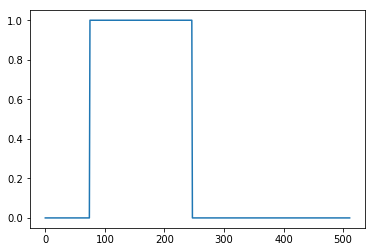

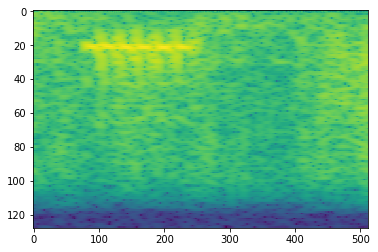

In [23]:
files = os.listdir(clips_dir)
X,y = generate_sample_call(files,clips_dir,call_type=None,mel=False)
plt.plot(y)
plt.show()
plt.imshow(X.T,aspect='auto')
plt.show()

In [11]:
print(labels)

      Unnamed: 0          t0          tf                   label  \
0              1   16.532643   16.532643                   START   
1              2   47.542569   47.542569          NN: VHMM003 2M   
2              3   57.451384   58.420725             AGG VHMF004   
3              4   61.571082   61.571082        NN: VHMF004 NEXT   
4              5  105.200387  105.200387        NN: VHMM002 NEXT   
5              6  159.860429  159.860429  NN: VHMM002+VHMM003 1M   
6              7  394.254629  394.427405                  CC1 SC   
7              8  597.513247  597.513247          NN: VHMM002 1M   
8              9  649.644477  649.644477                     END   
9             10   15.012303   15.012303                   START   
10            11  120.502531  120.502531                   PAUSE   
11            12  123.599209  123.599209                  RESUME   
12            13  180.163262  180.163262                   PAUSE   
13            14  181.400147  181.400147        

In [15]:
labels['t0'] > 20

0        False
1         True
2         True
3         True
4         True
5         True
6         True
7         True
8         True
9        False
10        True
11        True
12        True
13        True
14        True
15        True
16        True
17        True
18        True
19        True
20        True
21        True
22        True
23        True
24       False
25       False
26       False
27       False
28       False
29        True
         ...  
30002     True
30003     True
30004     True
30005     True
30006     True
30007     True
30008     True
30009     True
30010     True
30011     True
30012     True
30013     True
30014     True
30015     True
30016     True
30017     True
30018     True
30019     True
30020     True
30021     True
30022     True
30023     True
30024     True
30025     True
30026     True
30027     True
30028     True
30029     True
30030     True
30031     True
Name: t0, Length: 30032, dtype: bool